In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage as sk
import skimage.io as skio
from torch.distributions.categorical import Categorical
import torch

In [7]:
a = [1, 2, 3]
b = [1, 2, 3]
print(a==b)

True


In [16]:
m = Categorical(torch.tensor([0.1, 0.3, 0.5, 0.1]))
x = m.sample(sample_shape=torch.tensor([3]))
print(x)
print(m.log_prob(x))

tensor([2, 0, 1])
tensor([-0.6931, -2.3026, -1.2040])


In [17]:
a = torch.empty()
a.append(torch.tensor([1, 2, 3]))

TypeError: empty() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [3]:
n2 = np.load(r'../saved_models/vgg19/007/epoch-30/0/nearest-1_original_with_heatmap.npy')


In [103]:
def compute_overlap(bb_object):
    total_overlap = 0
    for j in range(0, len(bb_object)):
        for k in range(0, len(bb_object)):
            if j == k:
                continue

            l = bb_object[j]
            r = bb_object[k]

            dy = min(l[2], r[2]) - max(l[1], r[1])
            dx = min(l[4], r[4]) - max(l[3], r[3])
            
            if dx <= 0 or dy <= 0:
                overlap = 0
            else:
                SI = dx*dy
                SL = (l[2] - l[1])*(l[4] - l[3])
                SR = (r[2] - r[1])*(r[4] - r[3])
                SU = SL + SR - SI

                # Calculate the ratio to get overlap
                # Taking the min: get percent of smallest
                # bounding box is intersecting with the other bb
                overlap = SI / min(SL, SR)

            total_overlap += overlap
            
    # Remove Duplicates
    total_overlap /= 2
            
    return total_overlap

In [104]:
def bounding_box_overlap(bb_holder, n_prototypes, n_classes):
    protos_per_class = int(n_prototypes / n_classes)
    
    global_overlap = 0
    for i in range(0, n_classes):
        start_idx = i*protos_per_class
        end_idx = (i+1)*protos_per_class
        
        bb_class_specific = bb_holder[start_idx : end_idx]
        
        # First Column is the Img ID
        u, c = np.unique(bb_class_specific[:, 0], return_counts=True)
        shared_imgs = u[c > 1]
        
        bb_shared = [x for x in bb_class_specific if x[0] in shared_imgs]
        
        # Add Normalized Class Overlap (/ by # of overlaps computed)
        if len(bb_shared) > 0:
            class_overlap = compute_overlap(bb_shared) / len(bb_shared)
            global_overlap += class_overlap
        
    # Return the normalized overlap
    return global_overlap / n_classes

In [105]:
bb30 = np.load(r'../saved_models/vgg19/003/img/epoch-30/bb30.npy')

In [79]:
print(bb30.shape, bb10.shape)

(200, 6) (200, 6)


In [106]:
print(bb30[:10])

[[ 24  65 134  40 149   0]
 [ 58   0  58 111 161   1]
 [ 71  96 152  59 134   2]
 [105 113 165  91 153   3]
 [139  40 135  70 152   4]
 [155  33  79  83 192   5]
 [181  43 112  36 112   6]
 [221 106 166 109 163   7]
 [264  58 107 126 190   8]
 [273  69 116  70 143   9]]


In [81]:
print(bb10[:10])

[[  6  35  86  52 123   0]
 [ 54  91 131  40 182   1]
 [ 69  48 123   0  88   2]
 [104 120 192  36  94   3]
 [137  31  89 117 185   4]
 [155  33  76  91 192   5]
 [191  67 146  68 188   6]
 [238  60 111  69 132   7]
 [265  63 127 121 224   8]
 [299  67 119  29  90   9]]


In [107]:
bb30_test = bb30[:20]
print(bb30_test)

[[ 24  65 134  40 149   0]
 [ 58   0  58 111 161   1]
 [ 71  96 152  59 134   2]
 [105 113 165  91 153   3]
 [139  40 135  70 152   4]
 [155  33  79  83 192   5]
 [181  43 112  36 112   6]
 [221 106 166 109 163   7]
 [264  58 107 126 190   8]
 [273  69 116  70 143   9]
 [308  68 115  97 171  10]
 [342  54 119  45  99  11]
 [379   0  35  47 132  12]
 [394  94 133  65 148  13]
 [441  14  65 123 191  14]
 [451   0  86  98 185  15]
 [509  64 119  45 118  16]
 [528  30  83  93 151  17]
 [541  40 113  91 194  18]
 [578   0  56 134 186  19]]


In [93]:
bb10 = np.load(r'../saved_models/vgg19/004/img/epoch-10/bb10.npy')
bb10_0 = bb10[bb10[:, 5] == 0][:, 0]
bb10_1 = bb10[bb10[:, 5] == 1][:, 0]
bb10_2 = bb10[bb10[:, 5] == 2][:, 0]
bb10_3 = bb10[bb10[:, 5] == 3][:, 0]

In [95]:
bb10_indices = np.concatenate((bb10_0, bb10_1, bb10_2, bb10_3))
print(bb10_indices)

[ 10  27  16  11  15  33  44  43  59  43  70  85  85  88  74  96  92 118
 113  91]


In [108]:
images = []
for i in range(20):
    img = skio.imread('../saved_models/vgg19/003/img/epoch-30/prototype-img-original_with_self_act'+str(i)+'.png')
    images.append(sk.img_as_float(img))

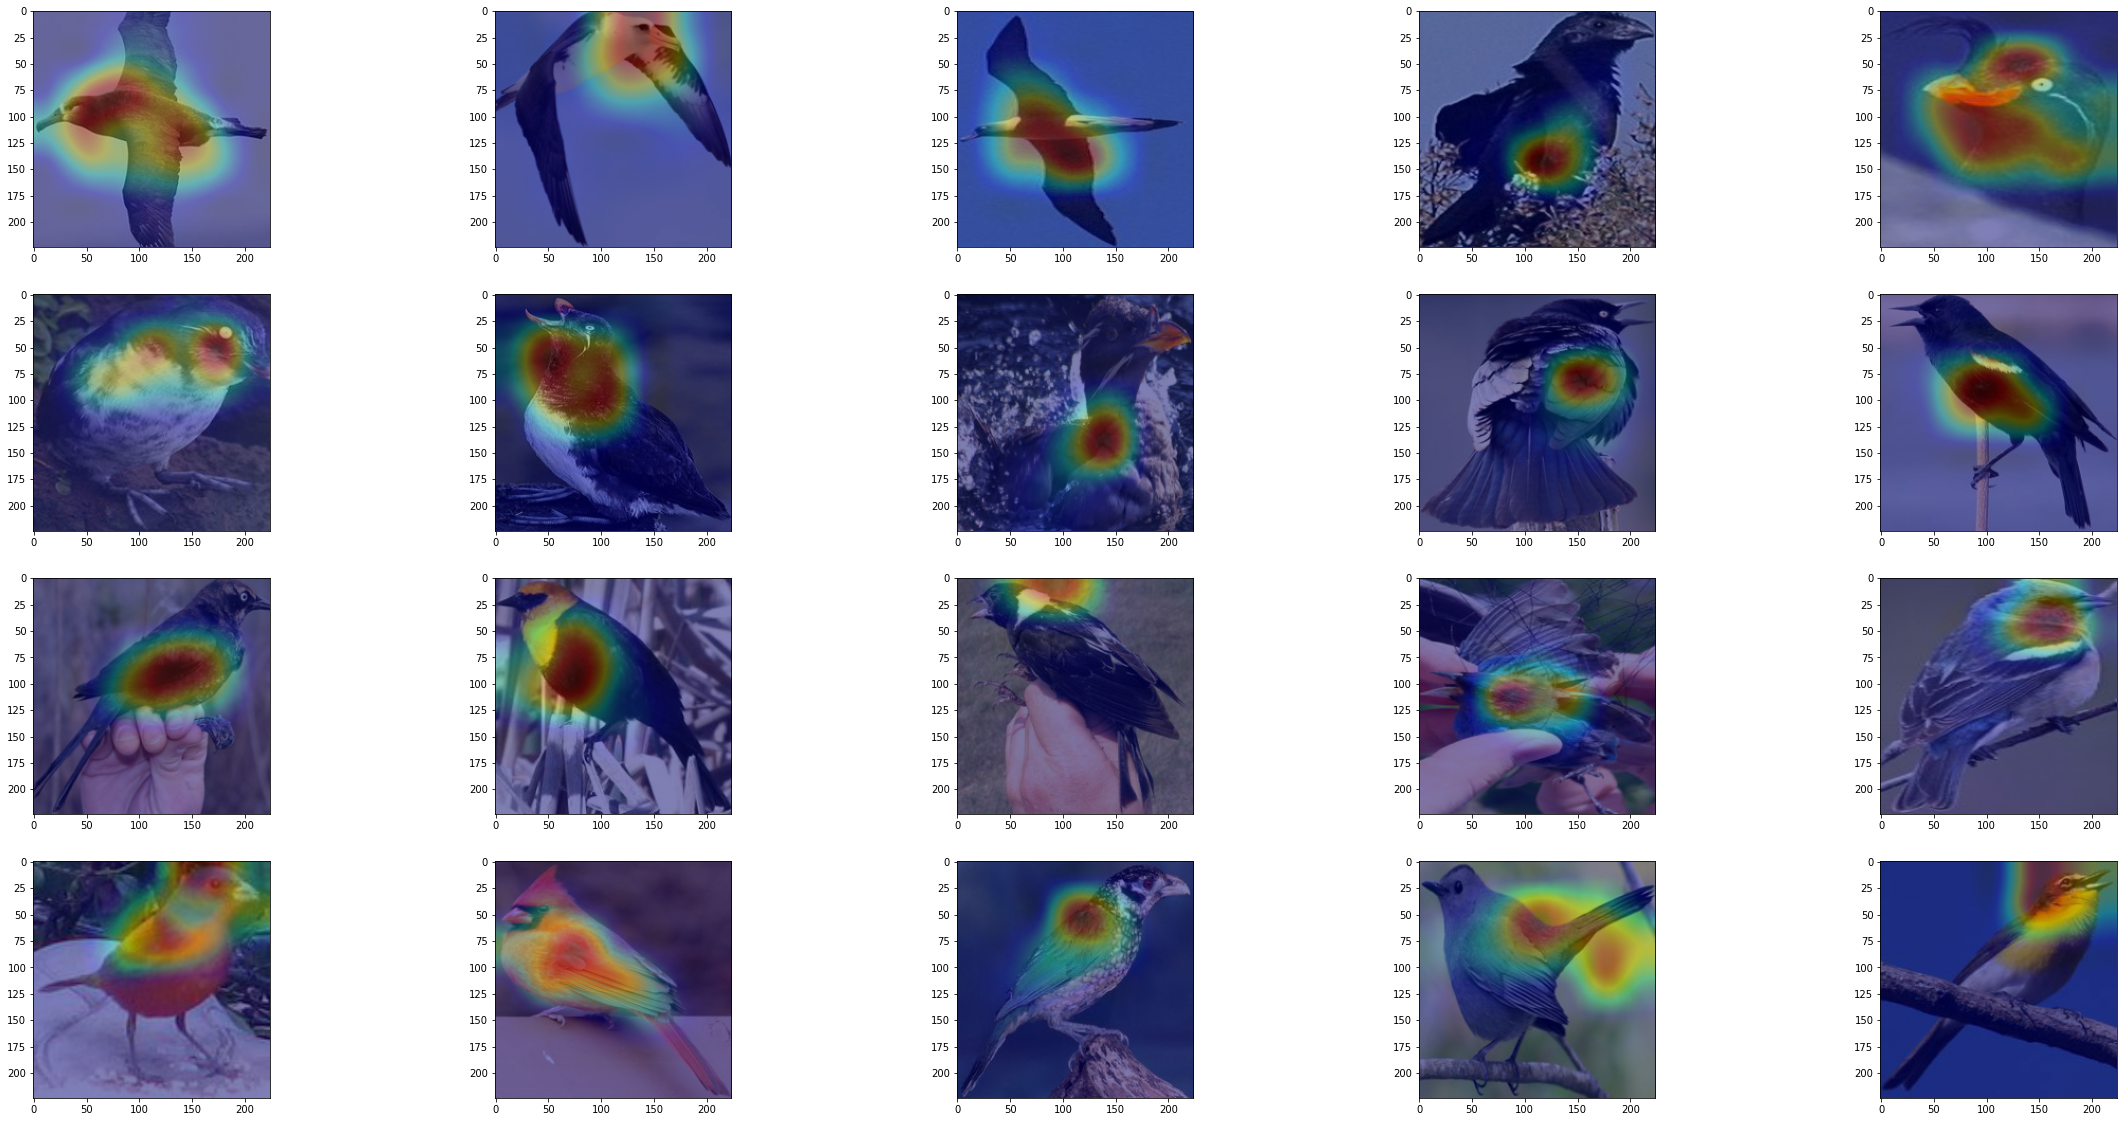

In [109]:
fig, axes = plt.subplots(4, 5, figsize=(40, 20))
for i in range(4):
    for j in range(5):
        axes[i][j].imshow(images[i*5+j])

In [110]:
bb30_test[:5, 5] = 0
bb30_test[5:10, 5] = 1
bb30_test[10:15, 5] = 2
bb30_test[15:20, 5] = 3
bb30_test[:5, 0] = 0
bb30_test[5:10, 0] = 1
bb30_test[10:15, 0] = 2
bb30_test[15:20, 0] = 3
print(bb30_test)

[[  0  65 134  40 149   0]
 [  0   0  58 111 161   0]
 [  0  96 152  59 134   0]
 [  0 113 165  91 153   0]
 [  0  40 135  70 152   0]
 [  1  33  79  83 192   1]
 [  1  43 112  36 112   1]
 [  1 106 166 109 163   1]
 [  1  58 107 126 190   1]
 [  1  69 116  70 143   1]
 [  2  68 115  97 171   2]
 [  2  54 119  45  99   2]
 [  2   0  35  47 132   2]
 [  2  94 133  65 148   2]
 [  2  14  65 123 191   2]
 [  3   0  86  98 185   3]
 [  3  64 119  45 118   3]
 [  3  30  83  93 151   3]
 [  3  40 113  91 194   3]
 [  3   0  56 134 186   3]]


In [111]:
bounding_box_overlap(bb30_test, 20, 4)

0.5094272263088209

In [112]:
compute_overlap(bb30_test[2:4, :])

0.5201612903225806

In [113]:
compute_overlap(bb30_test[0:2, :])

0.0

In [96]:
images_ep10 = []
for i in range(4):
    for j in range(5):
        img = skio.imread('../saved_models/vgg19/004/img/epoch-10/prototype-img-original_with_self_act'+str(bb10_indices[i*5+j])+'.png')
        images_ep10.append(sk.img_as_float(img))

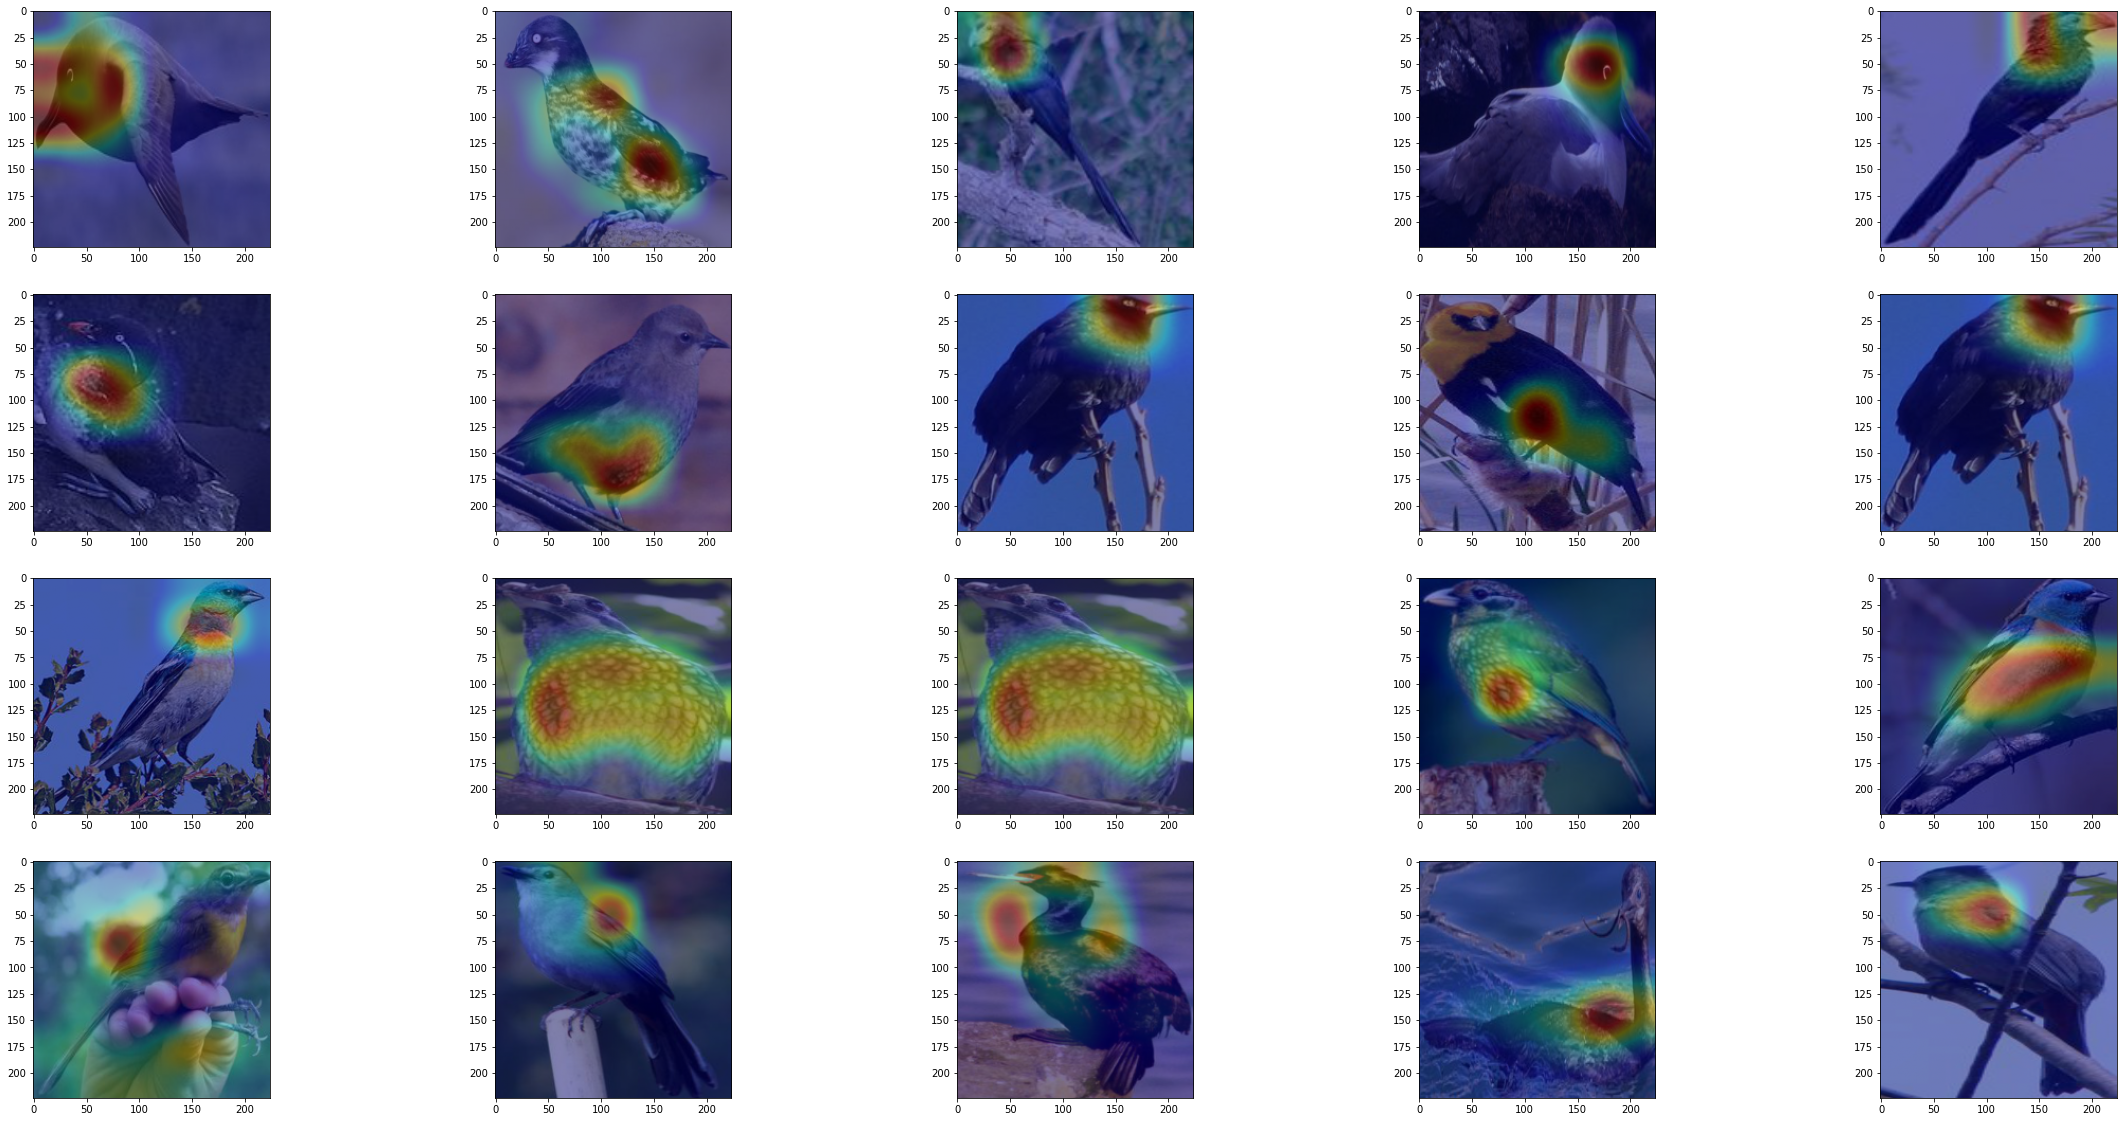

In [97]:
fig, axes = plt.subplots(4, 5, figsize=(40, 20))
for i in range(4):
    for j in range(5):
        axes[i][j].imshow(images_ep10[i*5+j])

In [114]:
im = np.load(r'../saved_models/vgg19/003/img/epoch-10/prototype-self-act0.npy')
print(im.shape)

(7, 7)
